In [1]:
using Flux

Wczytanie oraz przygotowanie danych

In [2]:
using Flux.Data.MNIST
using Images


images = MNIST.images();
labels = MNIST.labels();

In [3]:
preprocess(img) = vec(Float64.(img))#zmieniamy na float i na vektor bo tak będziemy pracować z siecia neuronową


xs = preprocess.(images[1:4000])# używamy tej funkci 5 tys razy aby stworzyc set uczacy
testowy_x = preprocess.(images[10001:12000])# set testowy

ys = [Flux.onehot(labels, 0:9) for labels in labels[1:4000]] # zmieniamy 5 na wertor [ 0 0 0 0 0 1 0 0 0 0 ]
testowy_y = [Flux.onehot(labels, 0:9) for labels in labels[10001:12000]]

2000-element Vector{Flux.OneHotVector}:
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 ⋮
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

Wczytujemy baze danych MNIST z zdjeciami liczb 
Mamy 60 tys zdjec (imagies) i podpisów do nich(labels)
images to jedno wymiarowa tablica dwuwyiarowych macierzy 28x28
images[1] = to jedno zdjecie

Tworzenie grafu

In [4]:
#bebechy
abstract type GraphNode end
abstract type Operator <: GraphNode end

struct Constant{T} <: GraphNode
    output :: T
end

mutable struct Variable <: GraphNode
    output :: Any
    gradient :: Any
    name :: String
    Variable(output; name="?") = new(output, nothing, name)
end

mutable struct ScalarOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    ScalarOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

mutable struct BroadcastedOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    BroadcastedOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

import Base: show, summary
show(io::IO, x::ScalarOperator{F}) where {F} = print(io, "op ", x.name, "(", F, ")");
show(io::IO, x::BroadcastedOperator{F}) where {F} = print(io, "op.", x.name, "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

function visit(node::GraphNode, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        push!(order, node)
    end
    return nothing
end
    
function visit(node::Operator, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(order, node)
    end
    return nothing
end

function topological_sort(head::GraphNode)
    visited = Set()
    order = Vector()
    visit(head, visited, order)
    return order
end

reset!(node::Constant) = nothing
reset!(node::Variable) = node.gradient = nothing
reset!(node::Operator) = node.gradient = nothing

compute!(node::Constant) = nothing
compute!(node::Variable) = nothing
compute!(node::Operator) =
    node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        reset!(node)
    end
    return last(order).output
end

update!(node::Constant, gradient) = nothing
update!(node::GraphNode, gradient) = if isnothing(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed=1.0)
    result = last(order)
    result.gradient = seed
    @assert length(result.output) == 1 "Gradient is defined only for scalar functions"
    for node in reverse(order)
        backward!(node)
    end
    return nothing
end

function backward!(node::Constant) end
function backward!(node::Variable) end
function backward!(node::Operator)
    inputs = node.inputs
    gradients = backward(node, [input.output for input in inputs]..., node.gradient)
    for (input, gradient) in zip(inputs, gradients)
        update!(input, gradient)
    end
    return nothing
end


import Base: ^
^(x::GraphNode, n::GraphNode) = ScalarOperator(^, x, n)
forward(::ScalarOperator{typeof(^)}, x, n) = return x^n
backward(::ScalarOperator{typeof(^)}, x, n, g) = tuple(g * n * x ^ (n-1), g * log(abs(x)) * x ^ n)

import Base: sin
sin(x::GraphNode) = ScalarOperator(sin, x)
forward(::ScalarOperator{typeof(sin)}, x) = return sin(x)
backward(::ScalarOperator{typeof(sin)}, x, g) = tuple(g * cos(x))

import Base: *
import LinearAlgebra: mul!
# x * y (aka matrix multiplication)
*(A::GraphNode, x::GraphNode) = BroadcastedOperator(mul!, A, x)
forward(::BroadcastedOperator{typeof(mul!)}, A, x) = return A * x
backward(::BroadcastedOperator{typeof(mul!)}, A, x, g) = let
    #print("mul ")
    #print(g)
    tuple(g * x', A' * g)
end

# x .* y (element-wise multiplication)
Base.Broadcast.broadcasted(*, x::GraphNode, y::GraphNode) = BroadcastedOperator(*, x, y)
forward(::BroadcastedOperator{typeof(*)}, x, y) = return x .* y
backward(node::BroadcastedOperator{typeof(*)}, x, y, g) = let  #w*x
    #print("* ")
    𝟏 = ones(length(node.output))
    Jx = diagm(y .* 𝟏)# to zostaje tylko y wiec to dajesz
    Jy = diagm(x .* 𝟏)
    
    tuple(Jx' * g, Jy' * g)
end

Base.Broadcast.broadcasted(-, x::GraphNode, y::GraphNode) = BroadcastedOperator(-, x, y)
forward(::BroadcastedOperator{typeof(-)}, x, y) = return x .- y
backward(::BroadcastedOperator{typeof(-)}, x, y, g) = tuple(g,-g)

Base.Broadcast.broadcasted(+, x::GraphNode, y::GraphNode) = BroadcastedOperator(+, x, y)
forward(::BroadcastedOperator{typeof(+)}, x, y) = return x .+ y
backward(::BroadcastedOperator{typeof(+)}, x, y, g) = tuple(g, g)

import Base: sum
sum(x::GraphNode) = BroadcastedOperator(sum, x)
forward(::BroadcastedOperator{typeof(sum)}, x) = return sum(x)
backward(::BroadcastedOperator{typeof(sum)}, x, g) = let
    #print("sum ")
    #print(g)
    𝟏 = ones(length(x))
    J = 𝟏'
    tuple(J' * g)
end

Base.Broadcast.broadcasted(/, x::GraphNode, y::GraphNode) = BroadcastedOperator(/, x, y)
forward(::BroadcastedOperator{typeof(/)}, x, y) = return x ./ y
backward(node::BroadcastedOperator{typeof(/)}, x, y::Real, g) = let
    𝟏 = ones(length(node.output))#robisz jedynki 
    Jx = diagm(𝟏 ./ y)
    Jy = (-x ./ y .^2)
    tuple(Jx' * g, Jy' * g)
end


import Base: max
Base.Broadcast.broadcasted(max, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(max)}, x, y) = return max.(x, y)
backward(::BroadcastedOperator{typeof(max)}, x, y, g) = let
    Jx = diagm(isless.(y, x))
    #print("max ")
    Jy = diagm(isless.(x, y))
    tuple(Jx' * g, Jy' * g)
end

import Base: ^
Base.Broadcast.broadcasted(^, x::GraphNode, y::GraphNode) = BroadcastedOperator(^, x, y)
forward(::BroadcastedOperator{typeof(^)}, x, y) = return x.^y
backward(node::BroadcastedOperator{typeof(^)}, x, y::Real, g) = let
    #print("^ ")
    #print(g)
    𝟏 = ones(length(node.output))#robisz jedynki 
    Jx = diagm(y .* x .^ (y.-1))
    Jy = diagm(x .^ y .* log.(broadcast(abs, x)))
    tuple(Jx' * g, Jy' * g)
end

σ(x::GraphNode) = BroadcastedOperator(σ, x)
forward(::BroadcastedOperator{typeof(σ)}, x) = return @. one(x) / (one(x) + exp(-x))
backward(::BroadcastedOperator{typeof(σ)}, x, g) = let
    a=exp.(-x)
    Jx=diagm(@.a/(one(x)+a)^2)
    tuple(Jx' * g)
end

mean_squared_loss_in_graf(x::GraphNode, y::GraphNode) = BroadcastedOperator(mean_squared_loss_in_graf, x, y)
Base.Broadcast.broadcasted(mean_squared_loss_in_graf, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(mean_squared_loss_in_graf)}, x, y) = return (1/length(x)) .* sum((x .- y) .^ 2.0)
backward(::BroadcastedOperator{typeof(mean_squared_loss_in_graf)}, x, y, g) = let
    𝟏 = ones(length(y))#sum
    Jy = ((1/length(y)).*𝟏')'#sum*0.1
    #print(Jy)
    Jy=diagm(2 .* (x .- y))*Jy#^2
    #print(Jy)
    Jy=-Jy#x-y
    #print(Jy)
    Jx=Jy#test
    tuple(Jx * g, Jy * g)
end

backward (generic function with 12 methods)

In [5]:
# siec neuronowa
using LinearAlgebra
Wh  = Variable(randn(20,784), name="wh")#tworzymy losowe wagi 
Wo  = Variable(randn(10,20), name="wo")
x = Variable(xs[1], name="x")#wczytujemy pierwsze dane
y = Variable(Vector{Float64}(ys[1]), name="y")

#rózne funkcje aktywacji
#σ(x) = one(x) / (one(x) + exp(-x))#aktualnie używana ale zamieniona na czesc grafu
linear(x)=x
ReLU(x)= max.(Constant(0.0),x) 

epos=100

#różne funkcje strat
# function mean_squared_loss(y, ŷ)#aktualnie używana ale zamieniona na czesc grafu
#     return Constant(0.1) .* sum((y .- ŷ) .^ Constant(2.0))
# end   a *sum(b-x)^2

function cross_entropy(y, ŷ)
    return sum(Constant(-1.0).*y.*log.(ŷ))
end

#definicja grafu
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function net(x, wh, wo, y)
    x̂ = dense(wh, x, σ)
    x̂.name = "x̂"
    ŷ = dense(wo, x̂)
    ŷ.name = "ŷ"
    E = mean_squared_loss_in_graf(y, ŷ)
    E.name = "loss"
    return topological_sort(E)
end

graph = net(x, Wh, Wo, y)

for (i,n) in enumerate(graph)
    print(i, ". "); println(n)
end

1. var y
 ┣━ ^ 10-element Vector{Float64}
 ┗━ ∇ Nothing
2. var wo
 ┣━ ^ 10×20 Matrix{Float64}
 ┗━ ∇ Nothing
3. var wh
 ┣━ ^ 20×784 Matrix{Float64}
 ┗━ ∇ Nothing
4. var x
 ┣━ ^ 784-element Vector{Float64}
 ┗━ ∇ Nothing
5. op.?(typeof(mul!))
6. op.x̂(typeof(σ))
7. op.ŷ(typeof(mul!))
8. op.loss(typeof(mean_squared_loss_in_graf))


In [6]:
forward!(graph)


9.425960847462731

In [7]:
backward!(graph)

In [8]:
# for (i,n) in enumerate(graph)
#     try
#         print(i, ". "); println(n.gradient)
#     catch
#         println("Constans")
#     end

# end

In [9]:
import ProgressMeter: @showprogress
using Flux: onecold
#funcje gradientowe
function steepest_descent(step)
    Wh.output -= step*Wh.gradient
    Wo.output -= step*Wo.gradient
end


function steepest_descent_momentum(step,changeWo,changeWh,momentum = 0.6)
    new_changeWh = step * Wh.gradient + momentum * changeWh
    new_changeWo = step * Wo.gradient + momentum * changeWo
    
    Wh.output -= new_changeWh
    Wo.output -= new_changeWo
    
    changeWh=new_changeWh
    changeWo=new_changeWo
    return changeWh,changeWo
end

#funkcja zmieniajaca kolejnosc setów
using Random
    function double_shuffle(set1,set2)
    @assert length(set1) == length(set2) "wielkości zbiorów do tasowania muszą być równę"
    temp_set1=copy(set1)
    temp_set2=copy(set2)
    new_order=shuffle(1:length(set1))
    i=0
    for order in new_order
        i+=1
        temp_set1[i]=set1[order]
        temp_set2[i]=set2[order]
    end
    return temp_set1,temp_set2
end


#funcje pokazujące postęp
function test(set_x,set_y)
    good_maches=0
        for i=1:length(set_x)
            x.output=set_x[i]
            forward!(graph)
            if onecold(Vector{Float64}(set_y[i])) == onecold(graph[7].output)
                good_maches+=1
            end
        end
    return 100.0*good_maches/float(length(set_y))
end

function loss_test(set_x,set_y)
    loss=0.0
        for i=1:length(set_x)
            x.output=set_x[i]
            y.output=Vector{Float64}(set_y[i])
            loss+=forward!(graph)
        end
    return loss/float(length(set_y))
end



loss_test (generic function with 1 method)

In [10]:
println("Acc zbioru uczącego:",test(xs,ys))
println("Acc zbuoru testowo:",test(testowy_x,testowy_y))
println("Straty zbioru uczącego:",loss_test(xs,ys))
println("Straty zbioru uczącego:",loss_test(testowy_x,testowy_y))

Acc zbioru uczącego:6.325
Acc zbuoru testowo:5.95
Straty zbioru uczącego:10.620312566256558
Straty zbioru uczącego:10.393272578227077


┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1423
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


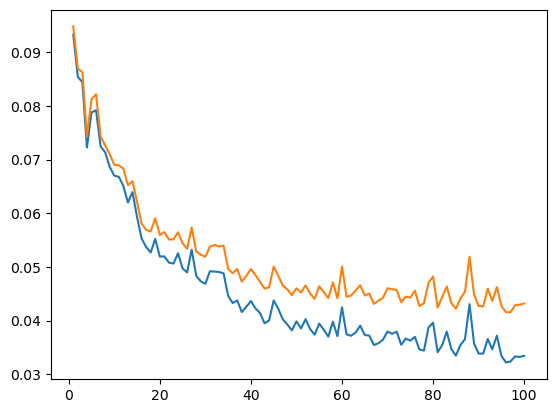

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001E86190>
 PyObject <matplotlib.lines.Line2D object at 0x0000000001E86130>

In [11]:
#mini batch
changeWh = zero(randn(20,784))
changeWo = zero(randn(10,20))
using PyPlot

j=0
batch_size=5
grad_wo=zeros(10,20)
grad_wh=zeros(20,784)

yyy = zeros(epos, 2)
@showprogress for i=1:epos
xs,ys=double_shuffle(xs,ys)
    for i=1:length(xs)
        x.output=xs[i]
        y.output=Vector{Float64}(ys[i])
        forward!(graph)
        backward!(graph)
        
        grad_wo+=Wo.gradient
        grad_wh+=Wh.gradient
        j+=1
        if j ==batch_size
            Wo.gradient = grad_wo/batch_size
            Wh.gradient = grad_wh/batch_size
            changeWh,changeWo = steepest_descent_momentum(0.2,changeWo,changeWh)
            j=0
            grad_wo=zeros(10,20)
            grad_wh=zeros(20,784)
        end
    end
yyy[i,1]=loss_test(xs,ys)
yyy[i,2]=loss_test(testowy_x,testowy_y)
end
xxx = 1:epos
plot(xxx, yyy)


In [12]:
println("Acc zbioru uczącego:",test(xs,ys))
println("Acc zbuoru testowo:",test(testowy_x,testowy_y))
println("Straty zbioru uczącego:",loss_test(xs,ys))
println("Straty zbioru uczącego:",loss_test(testowy_x,testowy_y))

Acc zbioru uczącego:76.15
Acc zbuoru testowo:70.05
Straty zbioru uczącego:0.03343774871164767
Straty zbioru uczącego:0.04319318845783661


In [17]:
using BenchmarkTools
@btime  backward!(graph)

  50.800 μs (118 allocations: 140.22 KiB)


In [19]:
    tmp_res = Vector{BenchmarkTools.Trial}()
    tmp_res = @benchmark backward!(graph)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  51.000 μs …   7.047 ms  ┊ GC (min … max): 0.00% … 98.10%
 Time  (median):     55.300 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   63.570 μs ± 116.655 μs  ┊ GC (mean ± σ):  6.58% ±  3.80%

   ▄▆▇█▇▅▅▄▃▃▃▂▂▁▁▁▁  ▁        ▁▂▂▃▂▁                          ▂
  ▇██████████████████████▇█▆█▇▇████████▇█▇▇▆▇▇▆▅▆▆▆▆▆▅▄▆▄▅▄▄▄▅ █
  51 μs         Histogram: log(frequency) by time       103 μs <

 Memory estimate: 140.22 KiB, allocs estimate: 118.